In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import sys
import glob
sys.path.append('../../../src')

from common import common, transform, json
from common.functions import cos_similarity, gauss
from common.json import IA_FORMAT, START_IDX, GA_FORMAT
from common.default import PASSING_DEFAULT
from individual_activity.individual_activity import IndividualActivity

# Indivisual Activity をロード

In [2]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'}
]

In [3]:
# homography
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, room_num, 'field.png')
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [4]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [5]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = os.path.join(common.data_dir, room_num, date, '*')
    else:
        dir_path = os.path.join(common.data_dir, room_num, date, opt, '*')
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        path_split = common.split_path(path)
        prefix = path_split[-6] + '_' + path_split[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.73it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.63it/s]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.37it/s]


# 特徴量抽出とデータ生成

In [8]:
def extract_features(frame_num, label1, label2, individuals):
    if label1 not in individuals or label2 not in individuals:
        return None
        
    individual1 = individuals[label1]
    pos1 = individual1.get_indicator('position', frame_num)
    body1 = individual1.get_indicator('body_vector', frame_num)
    arm1 = individual1.get_indicator('arm_ext', frame_num)
    wrist1 = [
        individual1.get_keypoints('LWrist', frame_num),
        individual1.get_keypoints('RWrist', frame_num)
    ]
    if pos1 is None or body1 is None or arm1 is None or None in wrist1:
        return None
    
    individual2 = individuals[label2]
    pos2 = individual2.get_indicator('position', frame_num)
    body2 = individual2.get_indicator('body_vector', frame_num)
    arm2 = individual2.get_indicator('arm_ext', frame_num)
    wrist2 = [
        individual2.get_keypoints('LWrist', frame_num),
        individual2.get_keypoints('RWrist', frame_num)
    ]
    if pos2 is None or body2 is None or arm2 is None or None in wrist2:
        return None
    
    # ポジション間の距離
    norm = np.linalg.norm(np.array(pos1) - np.array(pos2), ord=2)
    
    distance_prob = gauss(
        norm,
        mu=PASSING_DEFAULT['gauss_mu'],
        sigma=PASSING_DEFAULT['gauss_sig']
    )
    
    # 体の向き
    pos1 = np.array(pos1)
    pos2 = np.array(pos2)
    p1p2 = pos2 - pos1
    p2p1 = pos1 - pos2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = (np.average([p1_sim, p2_sim]) + 1) / 2  # [-1, 1] -> [0, 1]
    
    # 腕の上げ下げ
    arm_ave = np.average([arm1, arm2])
    
    # 手首の距離
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(wrist1[i]) - np.array(wrist2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    distance_prob_wrist = gauss(
        min_norm,
        mu=PASSING_DEFAULT['wrist_gauss_mu'],
        sigma=PASSING_DEFAULT['wrist_gauss_sig']
    )

    return [distance_prob, body_direction, arm_ave, distance_prob_wrist]
    # return [distance_prob, body_direction, arm_ave]

columns = ['distance', 'body direction', 'arm average', 'wrist distance']
# columns = ['distance', 'body direction', 'arm average']

In [9]:
x_dict = {}
y_dict = {}
for setting in data_settings:
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    dirs = sorted(glob.glob(f'{common.data_dir}/{room_num}/{date}/{opt}/*'))
    if dirs[-1].endswith('make_csv.csv'):
        dirs = dirs[:-1]

    for path in tqdm(dirs):
        file_num = common.split_path(path)[-1]
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in csv_data:
            frame_num = row[0]
            label1 = f'{room_num}_{file_num}_{row[1]}'
            label2 = f'{room_num}_{file_num}_{row[2]}'

            features = extract_features(frame_num, label1, label2, individuals)
            key = f'{room_num}_{file_num}_{row[1]}_{row[2]}'

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            x_dict[key].append(features)
            y_dict[key].append(row[3])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.12it/s]


In [10]:
for setting in data_settings:
    room_num = setting['room_num']
    print(room_num)
    
    y_lst_all = []
    for key, y_lst in y_dict.items():
        if key[:2] == room_num:
            y_lst_all += y_lst

    len_pass = len([i for i in y_lst_all if i == 1])
    len_not_pass = len([i for i in y_lst_all if i == 0])

    print(f'all length:{len(y_lst_all)}')
    print(f'passing: {len_pass}')
    print(f'not passing: {len_not_pass}')
    
print('total')
y_lst_all = []
for key, y_lst in y_dict.items():
    y_lst_all += y_lst

len_pass = len([i for i in y_lst_all if i == 1])
len_not_pass = len([i for i in y_lst_all if i == 0])

print(f'all length:{len(y_lst_all)}')
print(f'passing: {len_pass}')
print(f'not passing: {len_not_pass}')

02
all length:184535
passing: 628
not passing: 183907
08
all length:166060
passing: 1085
not passing: 164975
09
all length:101928
passing: 346
not passing: 101582
total
all length:452523
passing: 2059
not passing: 450464


In [11]:
# setting random seed
SEED = 64
np.random.seed(SEED)

train_len = int(len(x_dict) * 0.7)

random_keys = np.random.choice(
    list(x_dict.keys()),
    size=len(x_dict),
    replace=False
)

train_keys = random_keys[:train_len]
test_keys = random_keys[train_len:]

x_train_dict = {key: x_dict[key] for key in train_keys}
y_train_dict = {key: y_dict[key] for key in train_keys}

x_test_dict = {key: x_dict[key] for key in test_keys}
y_test_dict = {key: y_dict[key] for key in test_keys}


In [12]:
train_1 = {key: y_dict[key] for key in train_keys if 1 in y_dict[key]}
print(len(train_1))
train_0 = {key: y_dict[key] for key in train_keys if 0 in y_dict[key]}
print(len(train_0))

train_1_frame = 0
train_0_frame = 0
for data in y_train_dict.values():
    train_1_frame += len([val for val in data if val == 1])
    train_0_frame += len([val for val in data if val == 0])
    
print(train_1_frame)
print(train_0_frame)

50
5583
1554
322840


In [13]:
test_1 = {key: y_dict[key] for key in test_keys if 1 in y_dict[key]}
print(len(test_1))
test_0 = {key: y_dict[key] for key in test_keys if 0 in y_dict[key]}
print(len(test_0))

test_1_frame = 0
test_0_frame = 0
for data in y_test_dict.values():
    test_1_frame += len([val for val in data if val == 1])
    test_0_frame += len([val for val in data if val == 0])
print(test_1_frame)
print(test_0_frame)

18
2393
505
127624


# 分布

In [14]:
def extract_feature(settings, x_dict, y_dict, col_num, is_pass):
    hist = {}
    for setting in settings:
        room_num, date = setting['room_num'], setting['date']
        
        hist_room = []
        for key, x_lst, y_lst in zip(x_dict.keys(), x_dict.values(), y_dict.values()):
            x_lst = np.array(x_lst)
            if room_num in key and is_pass in y_lst:
                hist_room += x_lst.T[col_num].tolist()
        hist[room_num] = hist_room
        
    return hist

## 受け渡し動作中の距離の分布を見る

In [15]:
hist_dist_1 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    0,
    1
)

0.7957791739244453
0.12854898821713415


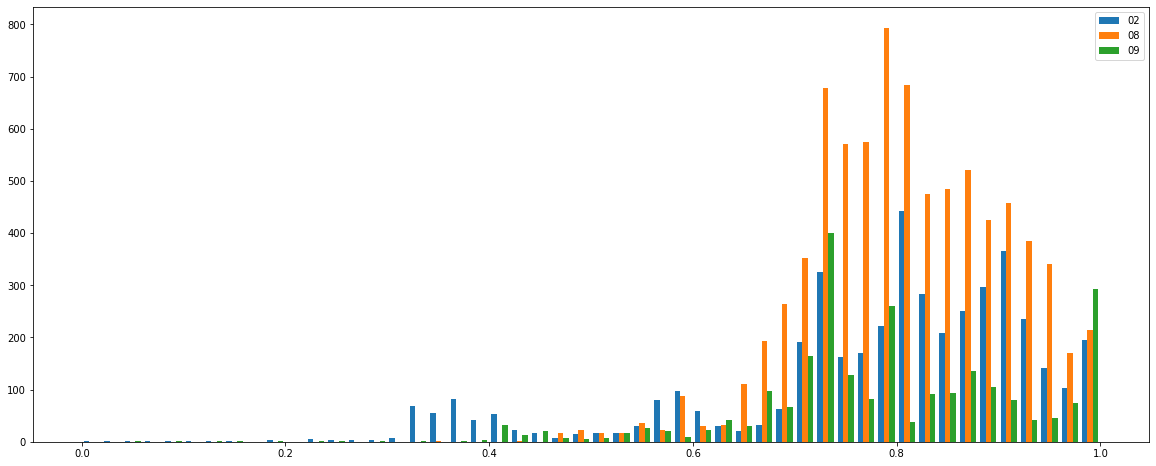

In [16]:
data = []
for vals in hist_dist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_dist_1.values(), bins=50, range=(0, 1), label=list(hist_dist_1.keys()))
# plt.vlines(np.mean(data), 0, 1000)
plt.legend()

In [17]:
hist_dist_0 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    0,
    0
)

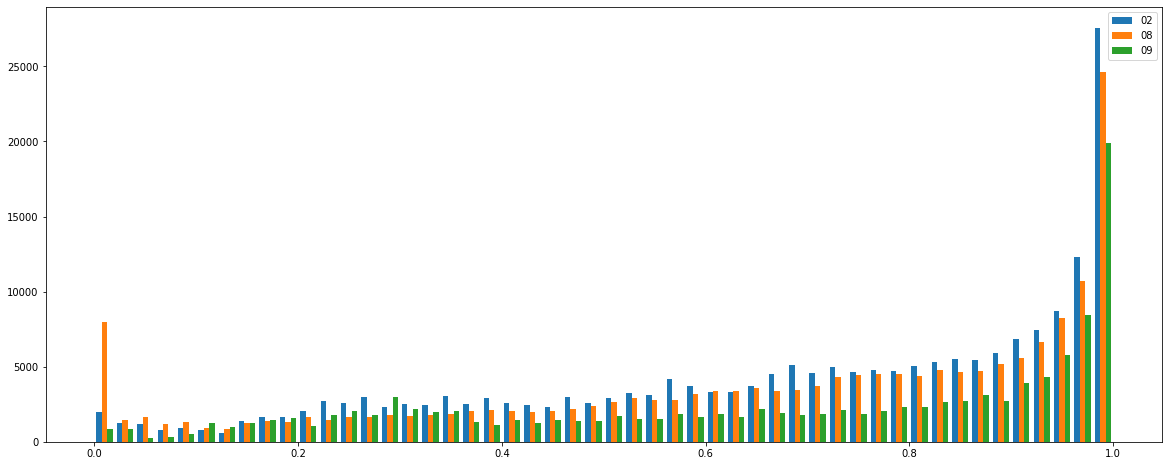

In [18]:
plt.figure(figsize=(20, 8))
plt.hist(hist_dist_0.values(), bins=50, range=(0, 1), label=list(hist_dist_0.keys()))
plt.legend()

## 受け渡し動作中の体の向きの分布を見る

In [19]:
hist_body_1 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    1,
    1
)

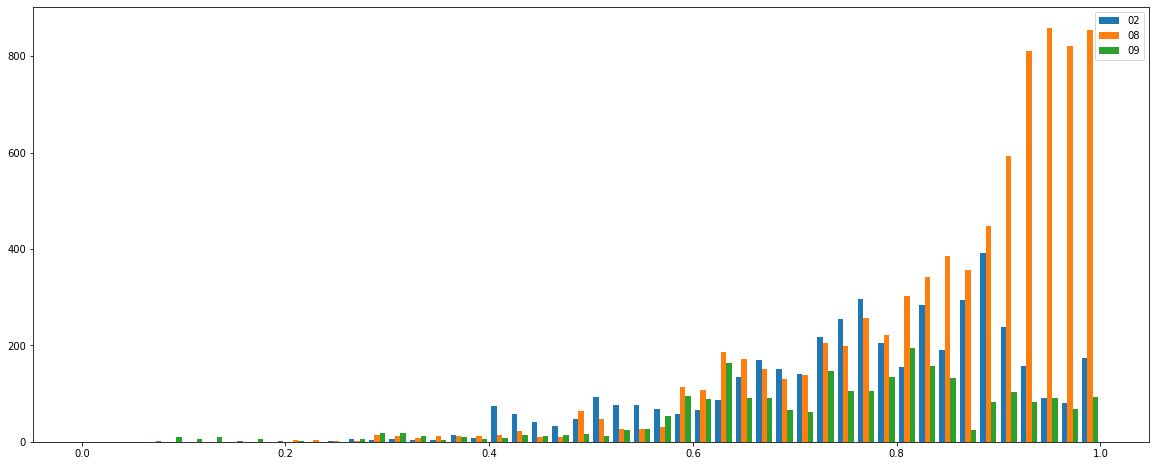

In [20]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_1.values(), bins=50, range=(0, 1), label=list(hist_body_1.keys()))
plt.legend()

In [21]:
hist_body_0 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    1,
    0
)

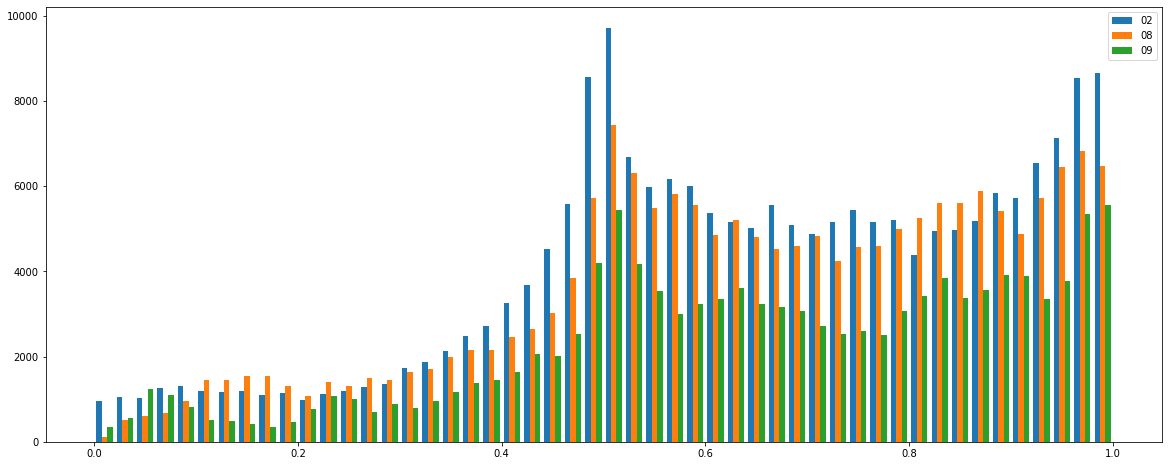

In [22]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_0.values(), bins=50, range=(0, 1), label=list(hist_body_0.keys()))
plt.legend()

## 受け渡し動作中の腕の上げ下げの分布を見る

In [23]:
hist_arm_1 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    2,
    1
)

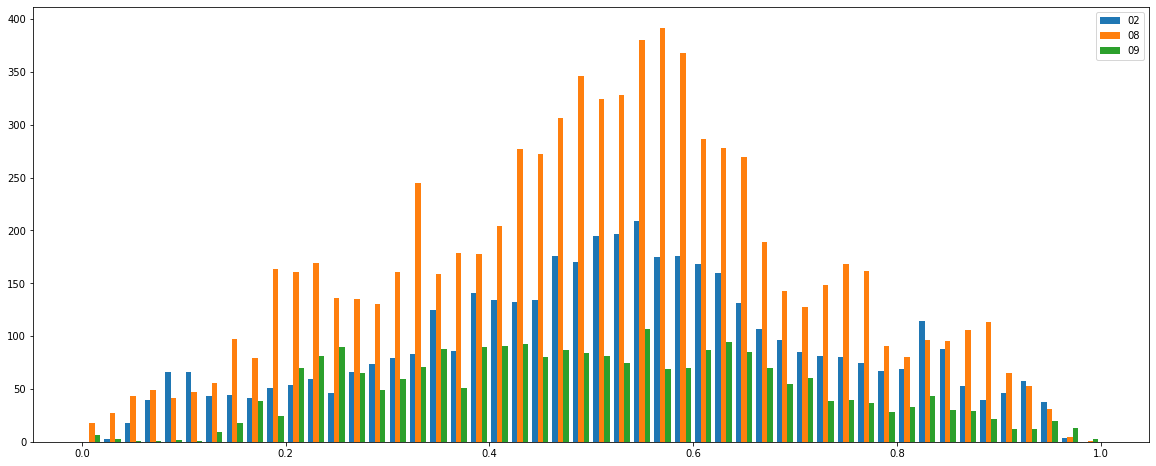

In [24]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_1.values(), bins=50, range=(0, 1), label=list(hist_arm_1.keys()))
plt.legend()

In [25]:
hist_arm_0 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    2,
    0
)

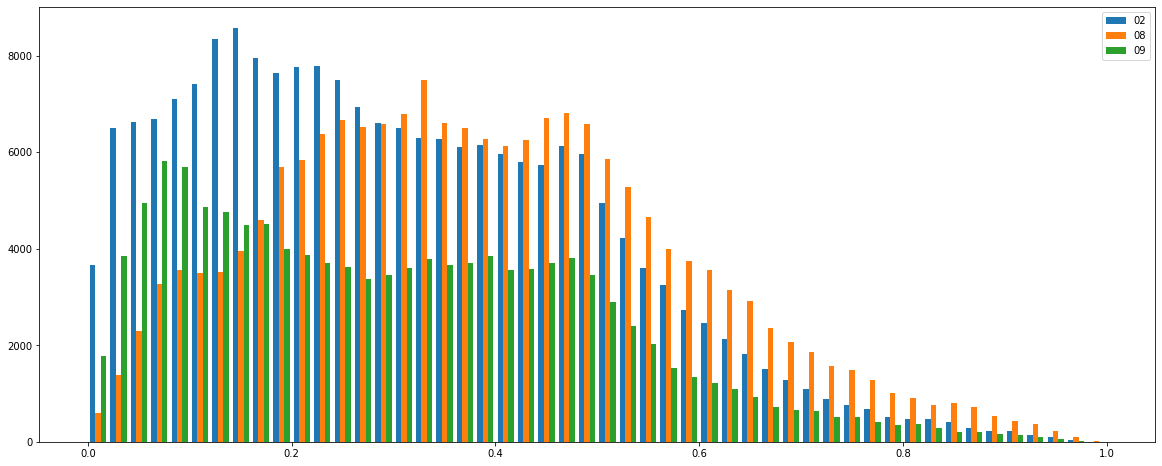

In [26]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_0.values(), bins=50, range=(0, 1), label=list(hist_arm_0.keys()))
plt.legend()

## 受け渡し動作中の手首の距離の分布を見る

In [27]:
hist_wrist_1 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    3,
    1
)

0.3007973489303944
0.3569433708795062


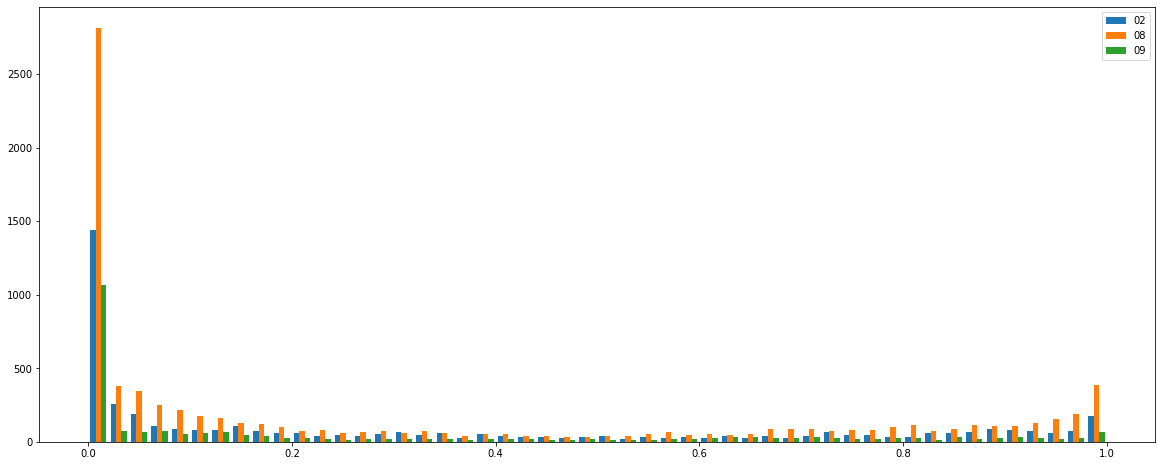

In [28]:
data = []
for vals in hist_wrist_1.values():
    for val in vals:
        if val < 2000:
            data.append(val)
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_1.values(), bins=50, range=(0, 1), label=list(hist_wrist_1.keys()))
plt.legend()

In [29]:
hist_wrist_0 = extract_feature(
    data_settings,
    x_dict,
    y_dict,
    3,
    0
)

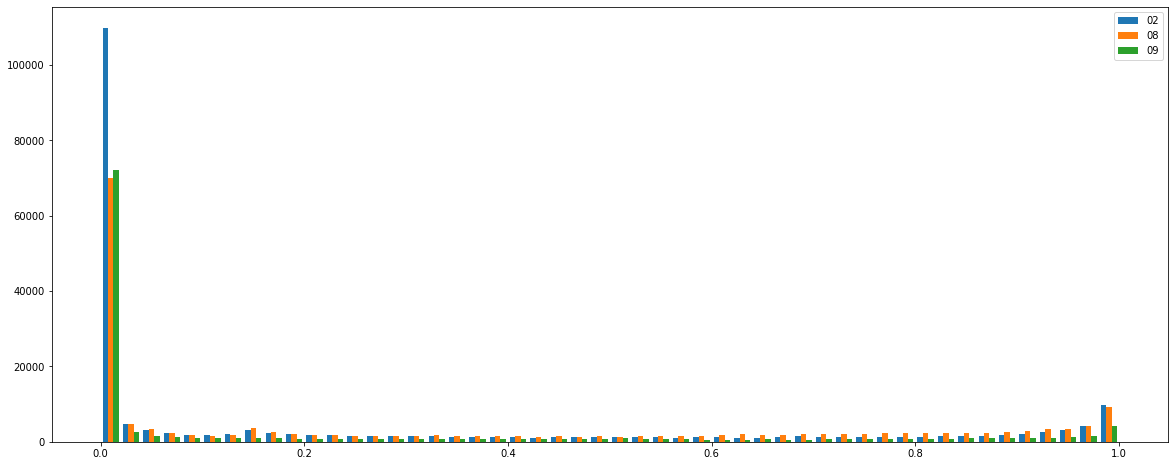

In [30]:
plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_0.values(), bins=50, range=(0, 1), label=list(hist_wrist_0.keys()))
plt.legend()

# 時系列でプロット

02_02_0_2


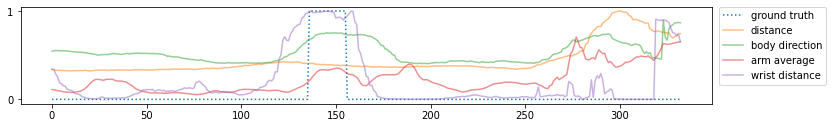

02_02_0_7


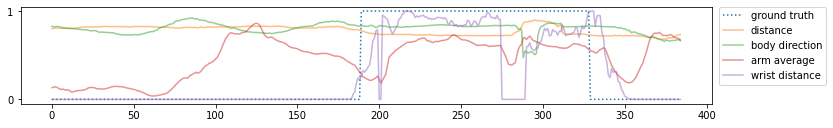

02_03_2_7


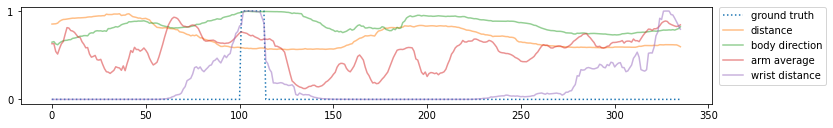

02_03_7_22


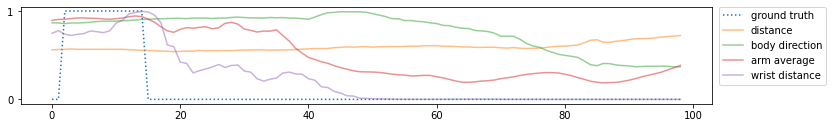

02_05_0_4


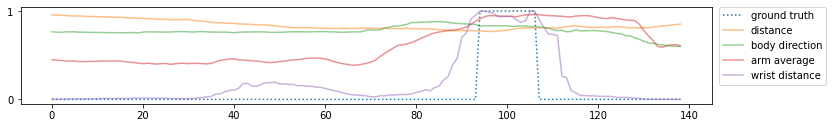

02_06_1_3


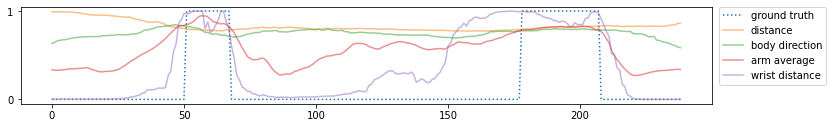

02_07_2_6


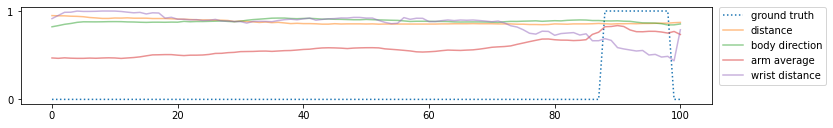

02_08_0_5


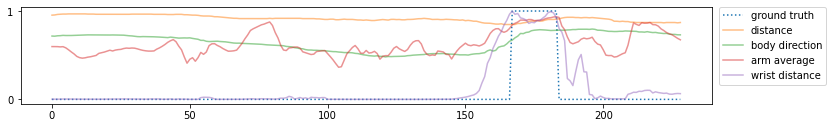

02_09_5_6


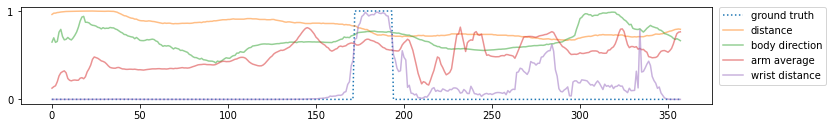

02_10_3_21


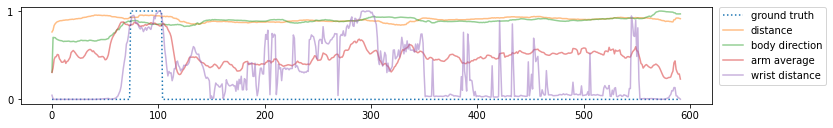

02_11_10_17


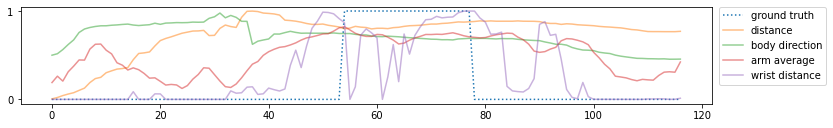

02_13_5_18


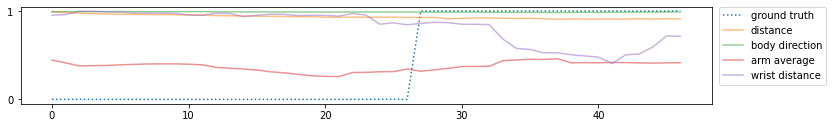

02_15_23_40


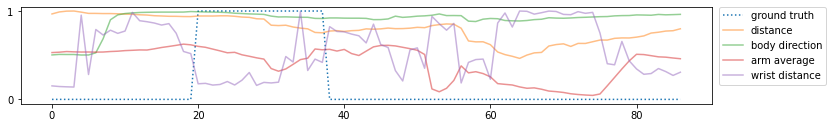

02_18_0_4


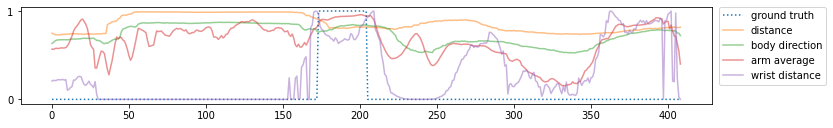

02_18_0_16


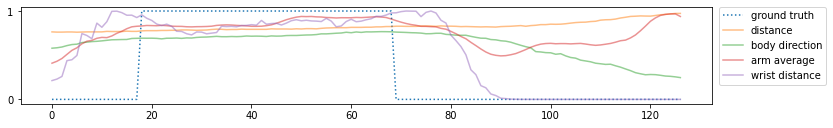

02_19_0_4


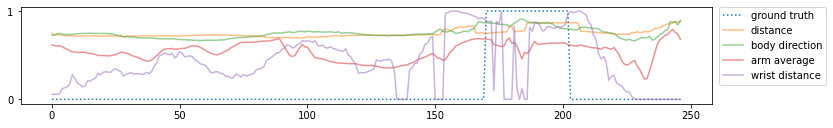

02_20_4_10


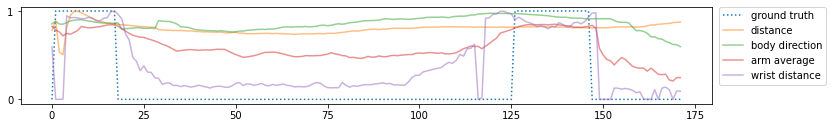

02_21_5_7


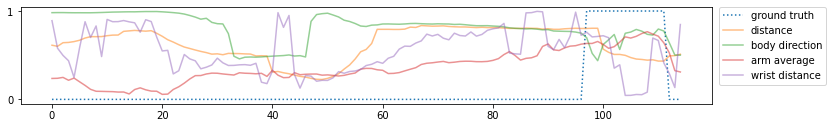

02_22_0_8


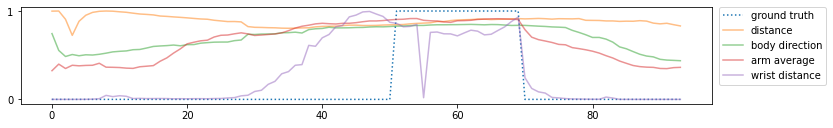

02_23_3_12


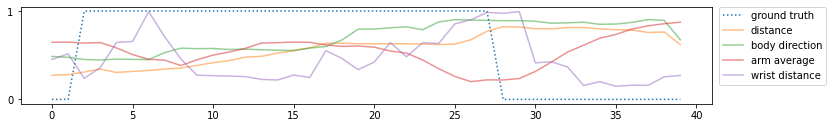

08_01_2_3


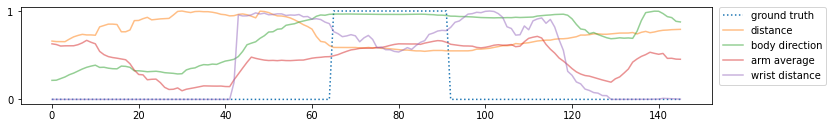

08_03_2_5


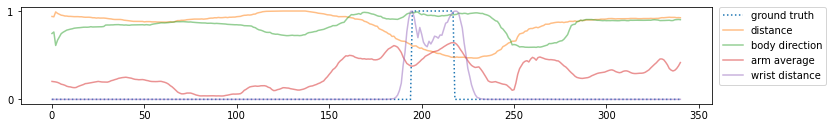

08_04_1_10


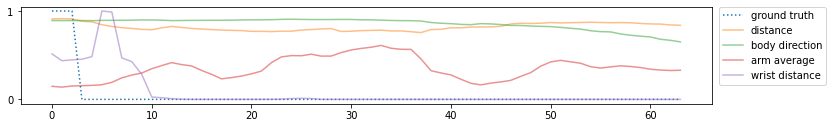

08_05_2_3


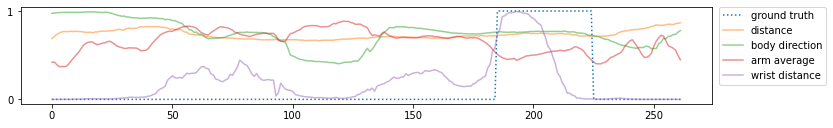

08_06_0_3


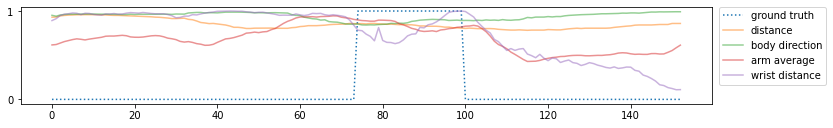

08_07_2_4


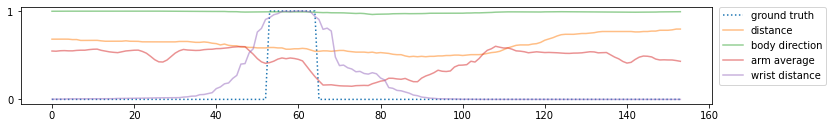

08_08_0_1


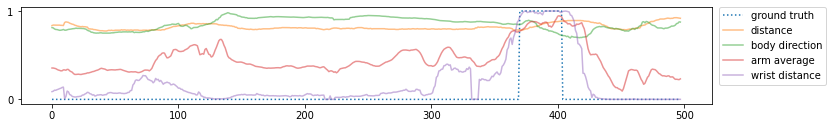

08_09_0_2


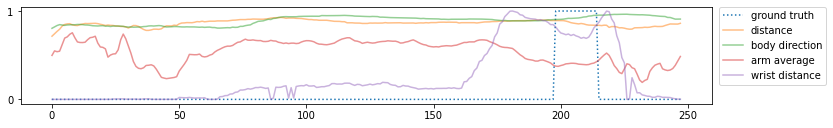

08_10_0_2


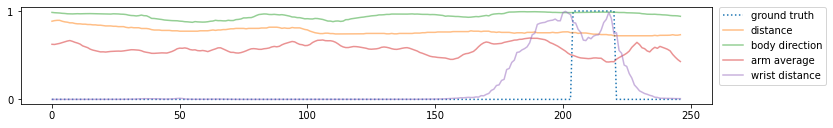

08_11_1_20


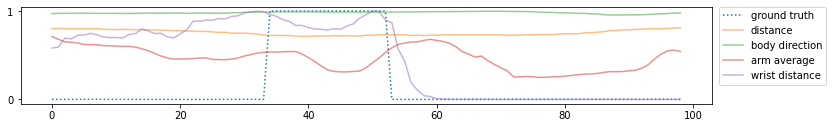

08_12_3_5


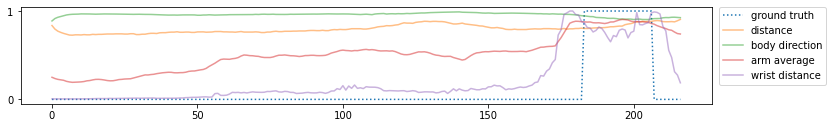

08_13_2_3


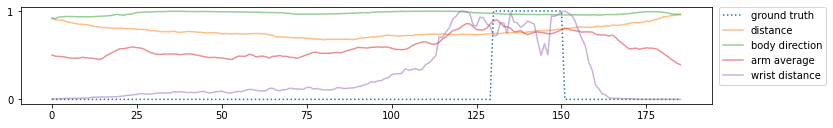

08_14_2_4


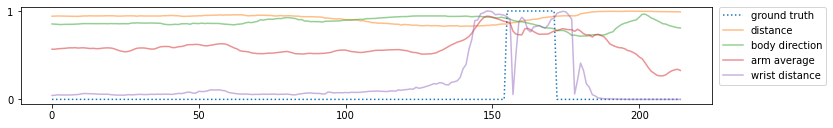

08_15_1_2


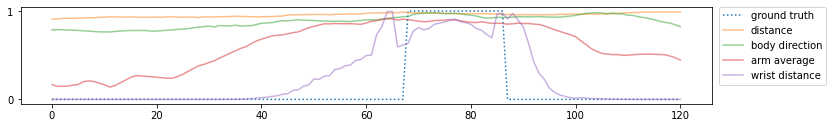

08_16_0_3


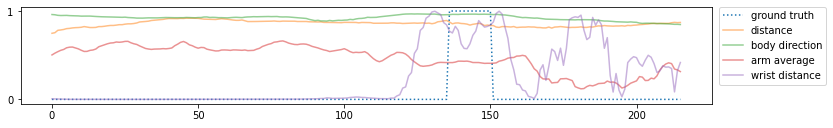

08_17_1_2


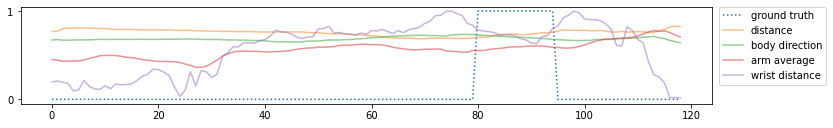

08_18_1_2


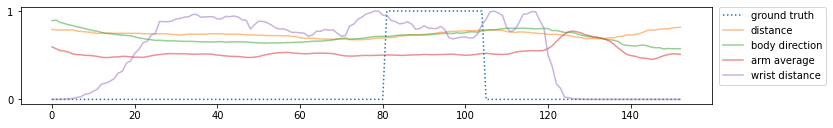

08_19_4_10


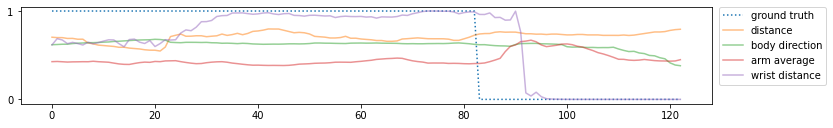

08_20_1_7


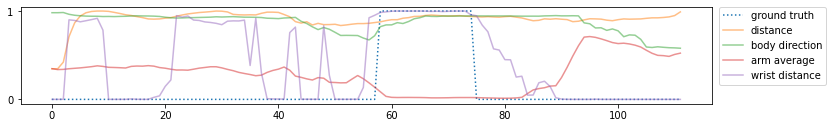

08_21_1_3


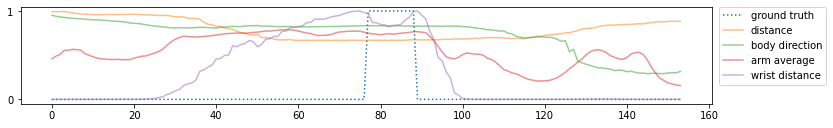

08_23_0_4


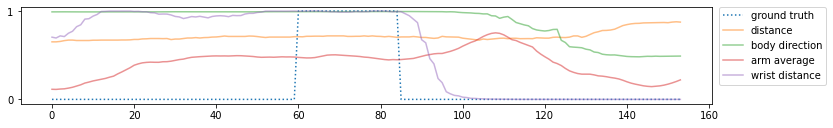

08_24_3_10


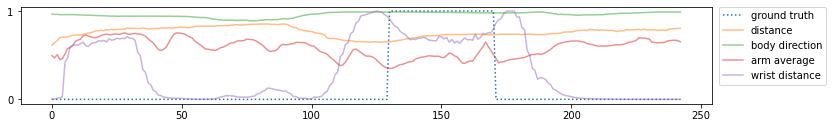

08_25_5_14


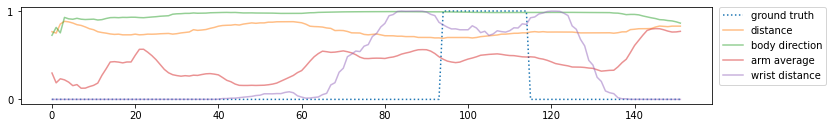

08_26_2_8


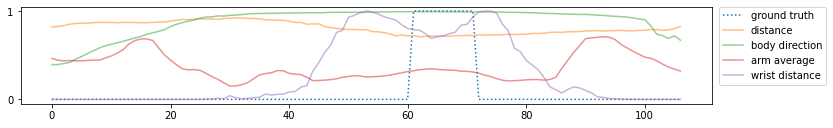

08_27_1_11


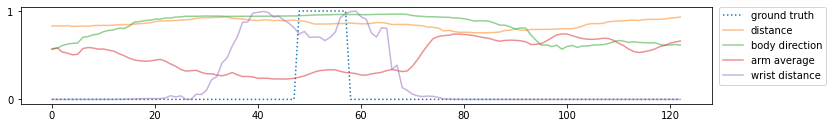

08_29_0_2


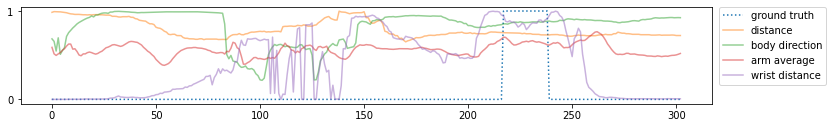

08_30_0_1


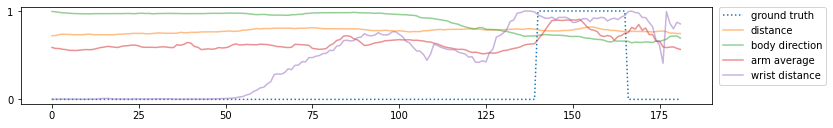

08_31_3_15


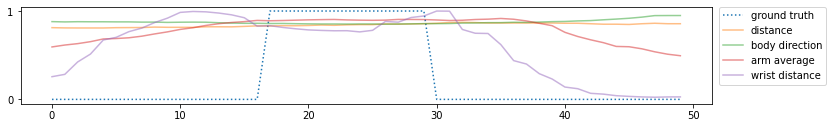

08_32_0_1


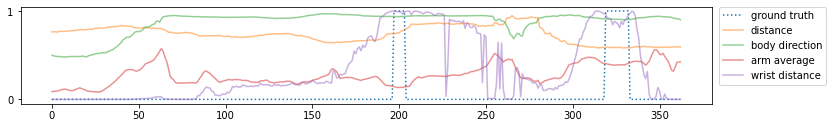

08_33_0_1


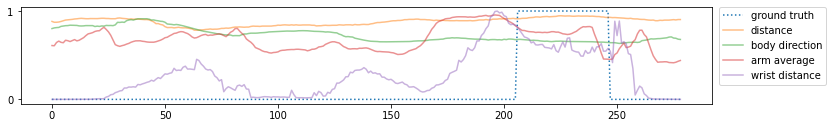

08_34_0_2


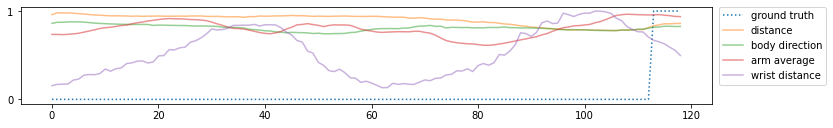

08_35_0_2


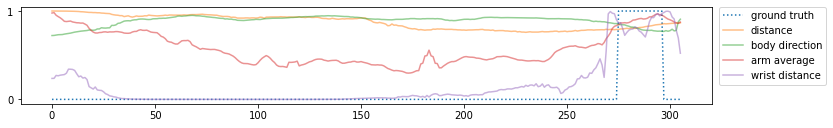

08_36_0_1


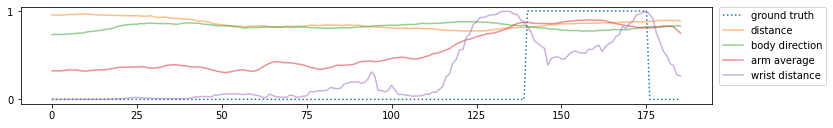

08_37_1_6


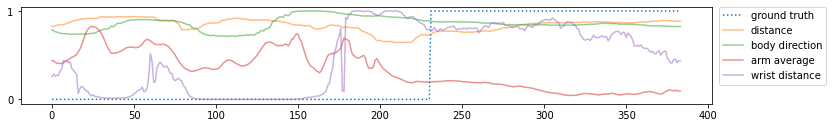

08_38_0_1


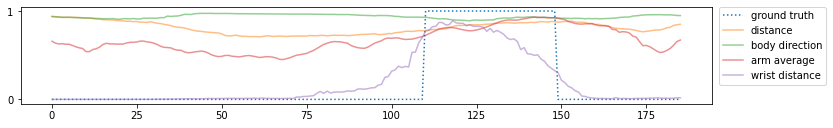

08_39_0_1


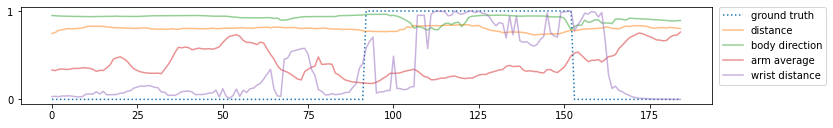

08_40_0_1


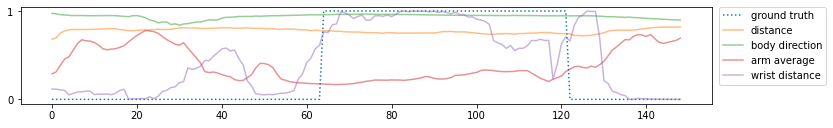

08_41_1_2


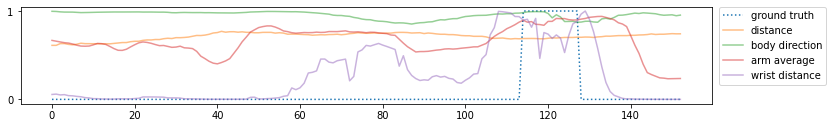

09_01_0_4


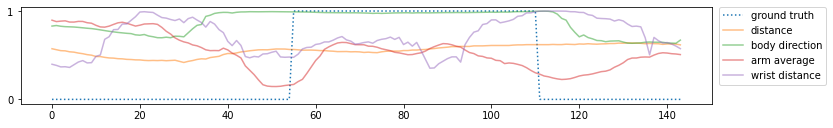

09_02_4_9


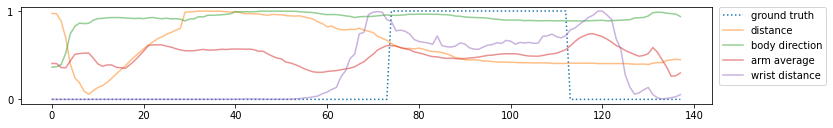

09_03_6_8


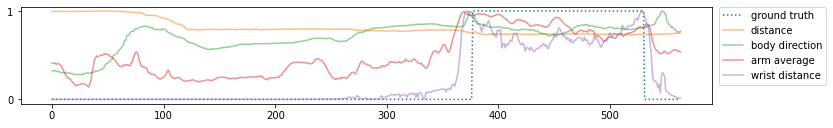

09_04_3_8


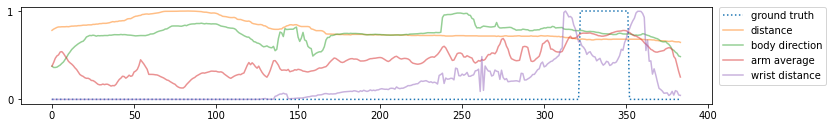

09_06_2_10


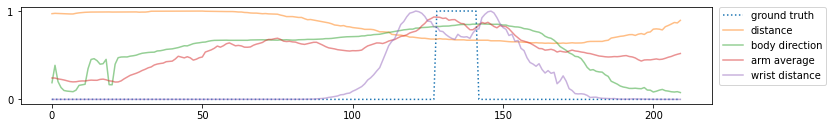

09_08_0_4


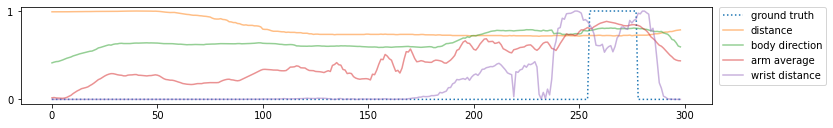

09_09_1_9


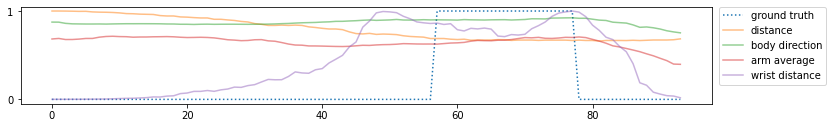

In [31]:
for key in x_dict.keys():
    x_lst = np.array(x_dict[key])
    y_lst = y_dict[key]

    if 1 not in y_lst:
        continue

    if len(x_lst) < 30:
        continue

    print(key)
    plt.figure(figsize=(10, 1.5))
    # plt.rcParams["font.size"] = 20
    # plt.rcParams["font.family"] = 'Times New Roman'
    plt.plot(y_lst, linestyle=':', label='ground truth')
    for i, x in enumerate(x_lst.T):
        plt.plot(x, alpha=0.5, label=columns[i])
    plt.ylim((-0.05, 1.05))
    plt.yticks([0, 1])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.subplots_adjust(left=0.04, right=1, bottom=0.1, top=1)

    plt.show()